# 1. Libraries and Data
In this first section I import the data into the work space, and give it the necessary format to be used during the stochastic modeling process.

In [158]:
# Libraries
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import matplotlib as mlp
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

%load_ext autoreload
%autoreload 2
import stochastic_modeling as stc


mlp.style.use('seaborn-notebook')
sns.set(font_scale=1.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
full_rates = pd.read_csv('historico_tasas_python.csv',index_col=0).astype(
    {'Fecha':'datetime64[ns]'}
).set_index('Fecha', drop=True)
full_rates

,TIBR,IBR Overnight,IBR 1M,IBR 3M,IBR 6M,DTF,IPC Anual,IPC Mensual,FED,UVR,...,IBC,USURA,TRM,DEV. TRM,LIBOR,SOFR,LEMPIRA/USD,DEV. LEMPIRA,COLON/USD,DEV. COLON
Fecha,,,,,,,,,,,,,,,,,,,,,
1999-01-01,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-02,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.192126,NaN,NaN,NaN,NaN,271.65,0.110907
1999-01-03,0.26,NaN,NaN,NaN,NaN,0.3433,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-04,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1542.11,0.182300,NaN,NaN,NaN,NaN,271.65,0.110680
1999-01-05,0.26,NaN,NaN,NaN,NaN,0.3406,0.1635,0.0017,NaN,NaN,...,0.4549,0.68235,1545.11,0.184601,NaN,NaN,NaN,NaN,271.85,0.111497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-05,0.02,0.01980,0.02039,0.02430,0.03000,0.0204,0.0444,0.0045,0.0025,286.3298,...,0.1708,0.25620,3786.05,-0.024666,0.001551,0.0005,24.2507,-0.014644,629.65,0.040916
2021-10-06,0.02,0.01976,0.02060,0.02456,0.03043,0.0204,0.0451,0.0038,0.0025,286.3726,...,0.1708,0.25620,3796.30,-0.012345,0.001561,0.0005,24.2507,-0.014536,629.12,0.041710
2021-10-07,0.02,0.01975,0.02048,0.02460,0.03038,0.0204,0.0451,0.0038,0.0025,286.4155,...,0.1708,0.25620,3788.03,-0.010123,0.001559,0.0005,24.2507,-0.014239,630.13,0.040351


In [106]:
monthly_rates = full_rates.groupby(pd.Grouper(freq='M')).last()

In [128]:
trm = monthly_rates['TRM']
trm = trm[:'2021-09']
trm

Fecha
1999-01-31    1582.90
1999-02-28    1568.30
1999-03-31    1533.51
1999-04-30    1604.44
1999-05-31    1671.67
               ...   
2021-05-31    3715.28
2021-06-30    3756.67
2021-07-31    3867.88
2021-08-31    3806.87
2021-09-30    3834.68
Freq: M, Name: TRM, Length: 273, dtype: float64

In [159]:
trm_gbm = stc.GBMRateSeries(trm,Np=10000)

In [160]:
trm_gbm.sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-09-30,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,...,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000,3834.680000
2021-10-31,3846.033503,3762.579055,3831.493421,3833.738324,3795.607226,3882.389933,3835.685969,3773.190081,3769.344458,3873.109992,...,3795.411779,3853.888457,3801.500824,3807.569494,3807.891053,3881.738001,3838.863274,3808.924357,3886.459047,3760.203026
2021-11-30,3832.139009,3767.097380,3784.663789,3811.502780,3854.648003,3840.138418,3816.311239,3780.416500,3767.858042,3866.050554,...,3896.200023,3828.716209,3770.113456,3820.759394,3830.918892,3881.129872,3798.783807,3847.070200,3833.407499,3788.941350
2021-12-31,3815.168718,3757.861983,3721.994150,3810.495850,3820.664865,3814.992338,3831.362669,3767.334379,3740.184258,3807.381577,...,3952.517867,3848.981942,3796.494932,3808.262036,3906.270816,3966.141000,3806.564581,3886.715131,3826.506416,3821.279532
2022-01-31,3840.318720,3798.543614,3693.271866,3821.362911,3854.185644,3874.881626,3866.660133,3803.506492,3763.955447,3816.486309,...,3931.206110,3867.473286,3818.569013,3789.208501,3938.687259,3967.218713,3774.176027,3947.904949,3839.937644,3862.315668


In [161]:
trm

Fecha
1999-01-31    1582.90
1999-02-28    1568.30
1999-03-31    1533.51
1999-04-30    1604.44
1999-05-31    1671.67
               ...   
2021-05-31    3715.28
2021-06-30    3756.67
2021-07-31    3867.88
2021-08-31    3806.87
2021-09-30    3834.68
Freq: M, Name: TRM, Length: 273, dtype: float64

(<Figure size 1080x720 with 1 Axes>, <AxesSubplot:>)

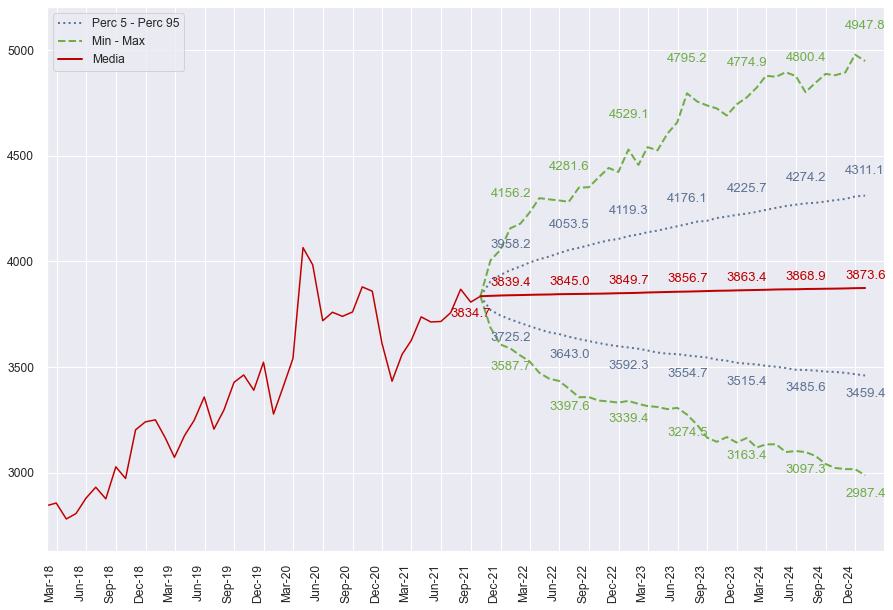

In [162]:
trm_gbm.plot_full_series('2018-01-01','2024-12-31',historical=trm, u_space=150, d_space=-100)

In [157]:
temp.select_dtypes(include='float64').min().min()

2747.7825204329756

In [17]:
temp[(temp['Fecha']>='2021-01-31') & (temp['Fecha']<='2024-12-31')]

,Fecha,TRM,min,max,mean,perc_5,perc_95
36,2021-01-31,3559.46,NaN,NaN,NaN,NaN,NaN
37,2021-02-28,3624.39,NaN,NaN,NaN,NaN,NaN
38,2021-03-31,3736.91,NaN,NaN,NaN,NaN,NaN
39,2021-04-30,3712.89,NaN,NaN,NaN,NaN,NaN
40,2021-05-31,3715.28,NaN,NaN,NaN,NaN,NaN
41,2021-06-30,3756.67,NaN,NaN,NaN,NaN,NaN
42,2021-07-31,3867.88,NaN,NaN,NaN,NaN,NaN
43,2021-08-31,3806.87,NaN,NaN,NaN,NaN,NaN
44,2021-09-30,3834.68,NaN,NaN,NaN,NaN,NaN
45,2021-10-31,3765.80,3765.800000,3765.800000,3765.800000,3765.800000,3765.800000


''

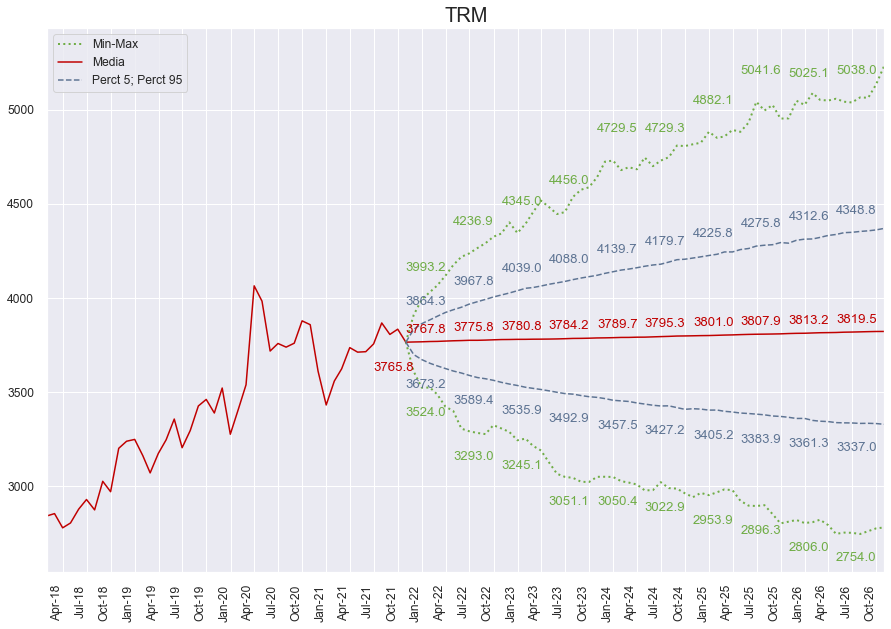

In [45]:
def perc_5(x):
    return x.quantile(0.05)
def perc_95(x):
    return x.quantile(0.95)
max_date = trm.idxmax().strftime('%b-%y')
max_val = trm.max()
min_date = trm.idxmin().strftime('%b-%y')
min_val = trm.min()
forecast = trm_gbm.sim_df.agg(['min','max', 'mean', perc_5, perc_95],axis=1)
forecast['Fecha'] = forecast.index
forecast.reset_index(drop=True, inplace=True)
trm_plot = trm['2018':].to_frame().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
temp = trm_plot.merge(forecast, how='outer', on='Fecha')
ax.plot(temp['Fecha'], temp['TRM'], color='#c00000')
ax.plot(temp['Fecha'], temp['min'], color='#70ad47', linestyle=':',
        linewidth=2, label='Min-Max')
ax.plot(temp['Fecha'], temp['max'], color='#70ad47', linestyle=':',
        linewidth=2)
ax.plot(temp['Fecha'], temp['mean'], color='#c00000', label='Media')
ax.plot(temp['Fecha'], temp['perc_5'], linestyle= '--', color='#5e7493', label='Perct 5; Perct 95')
ax.plot(temp['Fecha'], temp['perc_95'], '--', color='#5e7493')
month_fmt = mdates.MonthLocator(interval=3)
ax.xaxis.set_major_locator(month_fmt)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
plt.xticks(rotation=90, ha='right')
plt.text(trm.index.max()-relativedelta(months=4), trm[trm.index.max()]-150, trm[trm.index.max()], color='#c00000')
for date in forecast['Fecha']:
    if date.month%6==0:
        temp_min = round(temp.loc[temp['Fecha']==date, 'min'].item(),1)
        temp_max = round(temp.loc[temp['Fecha']==date, 'max'].item(),1)
        temp_mean = round(temp.loc[temp['Fecha']==date, 'mean'].item(),1)
        temp_95 = round(temp.loc[temp['Fecha']==date, 'perc_95'].item(),1)
        temp_5 = round(temp.loc[temp['Fecha']==date, 'perc_5'].item(),1)
        plt.text(
            x = date-relativedelta(months=2), 
            y = temp_min-150,
            s = temp_min,
            color = '#70ad47'
        )
        plt.text(
            x = date-relativedelta(months=2), 
            y = temp_max+150,
            s = temp_max,
            color = '#70ad47'
        )
        plt.text(
            x = date-relativedelta(months=2), 
            y = temp_mean+50,
            s = temp_mean,
            color = '#c00000'
        )
        plt.text(
            x = date-relativedelta(months=2), 
            y = temp_95+100,
            s = temp_95,
            color = '#5e7493'
        )
        plt.text(
            x = date-relativedelta(months=2), 
            y = temp_5-150,
            s = temp_5,
            color = '#5e7493'
        )
plt.title('TRM', fontsize=20)
plt.ylim(bottom=temp['min'].min()-200,top=temp['max'].max()+200)
plt.xlim(left=temp['Fecha'].min(), right=temp['Fecha'].max())
plt.legend()
;

# plt.axhline(y=max_val, color='g', linestyle='-')
# plt.axhline(y=min_val, color='g', linestyle='-')
#hline(max_val, xmin=temp['Fecha'].min(), xmax=temp['Fecha'].max(), color='green');

In [165]:
trm_gbm.sim_df/trm_gbm.sim_df.shift(1)-1

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,0.002961,-0.018802,-0.000831,-0.000246,-0.010189,0.012442,0.000262,-0.016035,-0.017038,0.010022,...,-0.010240,0.005009,-0.008652,-0.007070,-0.006986,0.012272,0.001091,-0.006717,0.013503,-0.019422
2021-11-30,-0.003613,0.001201,-0.012222,-0.005800,0.015555,-0.010883,-0.005051,0.001915,-0.000394,-0.001823,...,0.026555,-0.006532,-0.008257,0.003464,0.006047,-0.000157,-0.010440,0.010015,-0.013650,0.007643
2021-12-31,-0.004428,-0.002452,-0.016559,-0.000264,-0.008816,-0.006548,0.003944,-0.003460,-0.007345,-0.015175,...,0.014455,0.005293,0.006998,-0.003271,0.019669,0.021904,0.002048,0.010305,-0.001800,0.008535
2022-01-31,0.006592,0.010826,-0.007717,0.002852,0.008774,0.015698,0.009213,0.009602,0.006356,0.002391,...,-0.005392,0.004804,0.005814,-0.005003,0.008299,0.000272,-0.008509,0.015743,0.003510,0.010739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-05-31,0.015372,0.006526,0.000208,0.016631,-0.014492,-0.004037,-0.016445,-0.001598,0.023264,-0.007103,...,-0.020562,-0.005488,-0.006247,-0.006813,-0.005897,0.002299,0.009875,-0.003574,-0.028233,0.012437
2026-06-30,0.004023,0.001533,0.009416,-0.003558,0.000929,0.000667,-0.012044,-0.013911,-0.005669,0.000094,...,-0.003360,0.011689,-0.005890,0.004156,0.008740,0.002444,0.006842,-0.000818,0.019015,-0.010148
2026-07-31,0.011798,0.003512,-0.002604,-0.017805,-0.024122,0.005576,0.006773,0.001094,-0.010928,-0.009645,...,0.009729,-0.003181,0.002782,-0.004274,-0.002873,0.003712,0.006314,-0.012387,-0.006719,-0.000974
2026-08-31,0.003029,-0.009890,-0.008413,-0.011448,0.008672,-0.001806,-0.010900,-0.009253,0.001421,0.001312,...,-0.001679,0.001395,0.003101,0.024633,-0.008257,-0.019244,0.011524,0.016613,-0.001743,0.004253


In [50]:
temp

,Fecha,TRM,min,max,mean,perc_5,perc_95
0,2018-01-31,2844.14,NaN,NaN,NaN,NaN,NaN
1,2018-02-28,2855.93,NaN,NaN,NaN,NaN,NaN
2,2018-03-31,2780.47,NaN,NaN,NaN,NaN,NaN
3,2018-04-30,2806.28,NaN,NaN,NaN,NaN,NaN
4,2018-05-31,2879.32,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
101,2026-06-30,NaN,3013.296426,5152.861736,3830.883355,3335.556828,4339.440218
102,2026-07-31,NaN,3015.798859,5238.926979,3833.276759,3329.559352,4348.593565
103,2026-08-31,NaN,3006.569795,5258.186484,3835.319781,3332.162028,4365.261650
104,2026-09-30,NaN,2958.880653,5318.472888,3834.488419,3328.878905,4366.374766


In [21]:
trm.to_frame().columns.item()

'TRM'